In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import pandas as pd
import math

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# loading the dataset
columns=['id', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'context']
train_data = pd.read_csv('/kaggle/input/liar2-0/train.tsv', sep='\t', header=None, names=columns,index_col=False)
test_data = pd.read_csv('/kaggle/input/liar2-0/test.tsv', sep='\t', header=None, names=columns,index_col=False)
valid_data = pd.read_csv('/kaggle/input/liar2-0/valid.tsv', sep='\t', header=None, names=columns,index_col=False)

In [3]:
!pip install regex unidecode

In [4]:
import regex
import nltk
from unidecode import unidecode
from nltk.corpus import stopwords

# Download stopwords using nltk
nltk.download('stopwords')

def clean_text(text):
    text = regex.sub(r'\[.*?\]', '', text)
    text = regex.sub(r'https?://\S+|www\.\S+', '', text) # removing links
    text = regex.sub(r'<.*?>', '', text) # Remove HTML tags
    text = regex.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = text.replace('\n', ' ')
    text = regex.sub(r'\b\w*\d\w*\b', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    # tokens = [word for word in text.split() if word not in stop_words]
    tokens = list(filter(lambda word: word not in stop_words, text.split()))
    text = ' '.join(tokens)
    text = unidecode(text) # Remove accents and convert to ASCII characters

    return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
X_train = train_data['statement']
y_train = train_data['label']
X_test = test_data['statement']
y_test = test_data['label']
X_val = valid_data['statement']
y_val = valid_data['label']
X_test[0]

'Building a wall on the U.S.-Mexico border will take literally years.'

In [6]:
X_train = X_train.map(clean_text)
X_val = X_val.map(clean_text)
X_test = X_test.map(clean_text)

X_test[0]

'Building wall USMexico border take literally years'

In [7]:
print("Train data shape: ",X_test.shape)

Train data shape:  (1267,)


In [8]:
# Tokenization and Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_transformed = vectorizer.fit_transform(X_train).toarray()
X_val_transformed = vectorizer.transform(X_val).toarray()
X_test_transformed = vectorizer.transform(X_test).toarray()


# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_transformed, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_transformed, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_transformed, dtype=torch.float32)

In [9]:
labels = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']
y_train = [labels.index(s) for s in y_train]
y_test = [labels.index(s) for s in y_test]
y_valid = [labels.index(s) for s in y_val]

for i in range(len(y_train)):
    if y_train[i] <= 2:
        y_train[i] = 1
    else:
        y_train[i] = 0

for i in range(len(y_test)):
    if y_test[i] <= 2:
        y_test[i] = 1
    else:
        y_test[i] = 0

for i in range(len(y_valid)):
    if y_valid[i] <= 2:
        y_valid[i] = 1
    else:
        y_valid[i] = 0

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

In [10]:
# DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train)
val_dataset = TensorDataset(X_val_tensor, y_valid)
test_dataset = TensorDataset(X_test_tensor, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads, num_layers):
        super(TransformerModel, self).__init__()

        # Embedding layer
        self.embedding = nn.Linear(input_dim, hidden_dim)

        # Positional Encoding
        self.positional_encoding = PositionalEncoding(d_model=hidden_dim)

        # Transformer Blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(hidden_dim, num_heads) for _ in range(num_layers)
        ])

        # Global Average Pooling
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)


        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        x = self.global_avg_pooling(x.permute(0, 2, 1)).squeeze(2)
        output = self.fc(x)
#         output = torch.sigmoid(output)

        return output


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=128):
        super(PositionalEncoding, self).__init__()
        self.position_encoding = torch.tensor([[torch.sin(torch.tensor(pos / (10000.0 ** (i // 2 * 2.0 / d_model)))) if i % 2 == 0 else torch.cos(torch.tensor(pos / (10000.0 ** ((i) // 2 * 2.0 / d_model)))) for i in range(d_model)] for pos in range(max_len)])
        self.position_encoding = self.position_encoding.unsqueeze(0).transpose(0, 1)

    def forward(self, x):
        x = x + self.position_encoding[:x.size(0), :].cuda()
        return x

In [12]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        self.head_dim = hidden_dim // num_heads

        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)

        self.fc_out = nn.Linear(hidden_dim, hidden_dim)
        
        
    def forward(self, query, key, value):
        batch_size = query.shape[0]        
        Query = self.query(query).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        Key = self.key(key).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        Value = self.value(value).view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        
        attention_scores = torch.matmul(Query, Key.permute(0, 1, 3, 2)) / math.sqrt(self.head_dim)
        attention = torch.softmax(attention_scores, dim=-1)

        outputs = torch.matmul(attention, Value).permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.hidden_dim)
        outputs = self.fc_out(outputs)
        return outputs

In [13]:
class Feedforward(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout):
        super(Feedforward, self).__init__()

        self.fc1 = nn.Linear(hidden_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, hidden_dim, num_heads, pf_dim=512, dropout=0.1):
        super(TransformerBlock, self).__init__()

        self.attention = MultiHeadAttention(hidden_dim, num_heads)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)

        self.feedforward = Feedforward(hidden_dim, pf_dim, dropout)
        self.norm2 = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        attention_output = self.attention(x, x, x)
        x = x + self.dropout(attention_output)
        x = self.norm1(x)

        ff_output = self.feedforward(x)
        x = x + self.dropout(ff_output)
        x = self.norm2(x)

        return x

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Instantiate the model
model = TransformerModel(input_dim=X_train_tensor.shape[1], hidden_dim=256, output_dim=1, num_heads=4, num_layers=6)
model = model.to(device)

In [15]:

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
best_acc = 0
# Training loop
num_epochs = 10
train_loss1 = []
val_loss1 = []
train_acc1 = []
val_acc1 = []
for epoch in range(num_epochs):
    train_batch_loss = []
    num_correct = 0
    num_samples = 0
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        # forward
        scores = model(data)
        loss = criterion(scores, targets.unsqueeze(1))
        train_batch_loss.append(loss.item())
        predictions = torch.round(torch.sigmoid(scores))
        num_correct += (predictions == targets.unsqueeze(1)).sum()
        num_samples += predictions.size(0)
        # print(" Epoch: {} | Batch: {} | Loss: {}".format(epoch, batch_idx, loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss1.append(sum(train_batch_loss)/len(train_batch_loss))
    train_acc1.append(float(num_correct)/float(num_samples))

    val_batch_loss = []
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            loss = criterion(scores, y.unsqueeze(1))
            val_batch_loss.append(loss.item())
            predictions = torch.round(torch.sigmoid(scores))
            num_correct += (predictions == y.unsqueeze(1)).sum()
            num_samples += predictions.size(0)
        # print("Got {} / {} with accuracy {}".format(num_correct, num_samples, float(num_correct)/float(num_samples)))


        acc = float(num_correct)/float(num_samples)
        
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "attn_liar1.pt")
        # print('Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'.format(epoch+1, train_loss, train_acc, val_loss, val_acc))
    
    val_acc1.append(acc)
    val_loss1.append(sum(val_batch_loss)/len(val_batch_loss))
    print('Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'.format(epoch+1, train_loss1[-1], train_acc1[-1], val_loss1[-1], val_acc1[-1]))



Epoch: 1, Train Loss: 0.6879, Train Acc: 0.5511, Valid Loss: 0.6815, Valid Acc: 0.5428
Epoch: 2, Train Loss: 0.6547, Train Acc: 0.6168, Valid Loss: 0.6611, Valid Acc: 0.6044
Epoch: 3, Train Loss: 0.6331, Train Acc: 0.6387, Valid Loss: 0.7096, Valid Acc: 0.5771
Epoch: 4, Train Loss: 0.6268, Train Acc: 0.6564, Valid Loss: 0.6676, Valid Acc: 0.6012
Epoch: 5, Train Loss: 0.6195, Train Acc: 0.6598, Valid Loss: 0.6619, Valid Acc: 0.6067
Epoch: 6, Train Loss: 0.6164, Train Acc: 0.6623, Valid Loss: 0.6777, Valid Acc: 0.5896
Epoch: 7, Train Loss: 0.6115, Train Acc: 0.6652, Valid Loss: 0.6695, Valid Acc: 0.6098
Epoch: 8, Train Loss: 0.6097, Train Acc: 0.6629, Valid Loss: 0.6968, Valid Acc: 0.5841
Epoch: 9, Train Loss: 0.6031, Train Acc: 0.6686, Valid Loss: 0.6861, Valid Acc: 0.5693
Epoch: 10, Train Loss: 0.5941, Train Acc: 0.6732, Valid Loss: 0.7281, Valid Acc: 0.6044


In [16]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

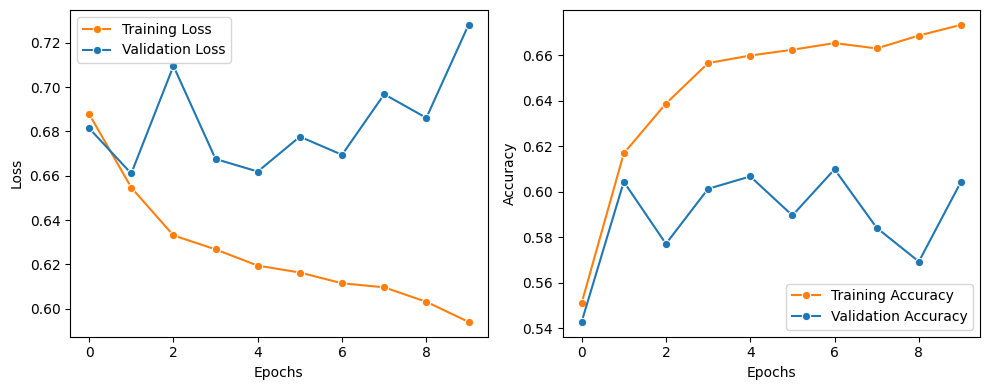

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, sub = plt.subplots(1, 2, figsize=(10, 4))

# Plot the data in each subplot using seaborn
sns.lineplot(train_loss1, ax=sub[0],label='Training Loss', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(val_loss1, ax=sub[0], label='Validation Loss', marker='o', linestyle='-', color='tab:blue')
# sub[0].set_title('Epochs = 10')
sub[0].set_xlabel('Epochs')
sub[0].set_ylabel('Loss')

# sns.lineplot(x=epochs, y=losses_2, ax=axes[0, 1])
sns.lineplot(train_acc1, ax=sub[1],label='Training Accuracy', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(val_acc1, ax=sub[1], label='Validation Accuracy', marker='o', linestyle='-', color='tab:blue')
# sub[1].set_title('Epochs = 10')
sub[1].set_xlabel('Epochs')
sub[1].set_ylabel('Accuracy')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [18]:
num_correct = 0
num_samples = 0
# load the best model
model.load_state_dict(torch.load("attn_liar1.pt", map_location=device))
model.eval()
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device=device)
        y = y.to(device=device)
        scores = model(x)
        predictions = torch.round(torch.sigmoid(scores))
        num_correct += (predictions == y.unsqueeze(1)).sum()
        num_samples += predictions.size(0)
        y_pred.extend(predictions.cpu().numpy())
    print("Got {} / {} with accuracy {} on test data".format(num_correct, num_samples, float(num_correct)/float(num_samples)))

y_pred = np.array(y_pred)

Got 758 / 1267 with accuracy 0.5982636148382005 on test data


In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.54      0.53      0.54       553
         1.0       0.64      0.65      0.65       714

    accuracy                           0.60      1267
   macro avg       0.59      0.59      0.59      1267
weighted avg       0.60      0.60      0.60      1267



# **Experiments by Changing optimizers**

**1. AdamW**

In [20]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5 )

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_acc = 0
# Training loop
num_epochs = 10
train_loss2 = []
val_loss2 = []
train_acc2 = []
val_acc2 = []
for epoch in range(num_epochs):
    train_batch_loss = []
    num_correct = 0
    num_samples = 0
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)
        # forward
        scores = model(data)
        loss = criterion(scores, targets.unsqueeze(1))
        train_batch_loss.append(loss.item())
        predictions = torch.round(torch.sigmoid(scores))
        num_correct += (predictions == targets.unsqueeze(1)).sum()
        num_samples += predictions.size(0)
        # print(" Epoch: {} | Batch: {} | Loss: {}".format(epoch, batch_idx, loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss2.append(sum(train_batch_loss)/len(train_batch_loss))
    train_acc2.append(float(num_correct)/float(num_samples))

    val_batch_loss = []
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            scores = model(x)
            loss = criterion(scores, y.unsqueeze(1))
            val_batch_loss.append(loss.item())
            predictions = torch.round(torch.sigmoid(scores))
            num_correct += (predictions == y.unsqueeze(1)).sum()
            num_samples += predictions.size(0)
        # print("Got {} / {} with accuracy {}".format(num_correct, num_samples, float(num_correct)/float(num_samples)))


        
        
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "attn_liar2.pt")
        # print('Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'.format(epoch+1, train_loss, train_acc, val_loss, val_acc))
    
    acc = float(num_correct)/float(num_samples)
    val_acc2.append(acc)
    val_loss2.append(sum(val_batch_loss)/len(val_batch_loss))
    print('Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'.format(epoch+1, train_loss2[-1], train_acc2[-1], val_loss2[-1], val_acc2[-1]))



Epoch: 1, Train Loss: 0.6113, Train Acc: 0.6630, Valid Loss: 0.6800, Valid Acc: 0.6083
Epoch: 2, Train Loss: 0.6008, Train Acc: 0.6691, Valid Loss: 0.7112, Valid Acc: 0.6059
Epoch: 3, Train Loss: 0.5906, Train Acc: 0.6708, Valid Loss: 0.6909, Valid Acc: 0.6083
Epoch: 4, Train Loss: 0.5837, Train Acc: 0.6749, Valid Loss: 0.7316, Valid Acc: 0.6020
Epoch: 5, Train Loss: 0.5716, Train Acc: 0.6806, Valid Loss: 0.7501, Valid Acc: 0.5911
Epoch: 6, Train Loss: 0.5656, Train Acc: 0.6733, Valid Loss: 0.8151, Valid Acc: 0.5903
Epoch: 7, Train Loss: 0.5571, Train Acc: 0.6776, Valid Loss: 0.8110, Valid Acc: 0.5755
Epoch: 8, Train Loss: 0.5504, Train Acc: 0.6766, Valid Loss: 0.8304, Valid Acc: 0.5833
Epoch: 9, Train Loss: 0.5399, Train Acc: 0.6847, Valid Loss: 0.9065, Valid Acc: 0.5763
Epoch: 10, Train Loss: 0.5363, Train Acc: 0.6792, Valid Loss: 0.8439, Valid Acc: 0.5685


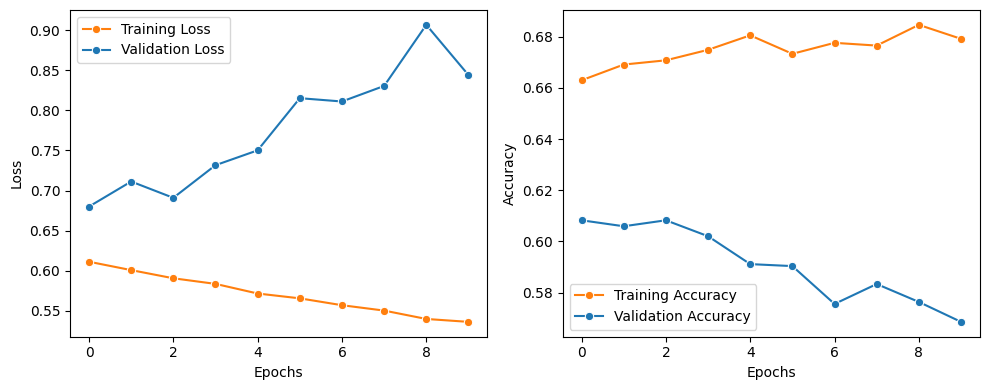

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, sub = plt.subplots(1, 2, figsize=(10, 4))

# Plot the data in each subplot using seaborn
sns.lineplot(train_loss2, ax=sub[0],label='Training Loss', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(val_loss2, ax=sub[0], label='Validation Loss', marker='o', linestyle='-', color='tab:blue')
# sub[0].set_title('Epochs = 10')
sub[0].set_xlabel('Epochs')
sub[0].set_ylabel('Loss')

# sns.lineplot(x=epochs, y=losses_2, ax=axes[0, 1])
sns.lineplot(train_acc2, ax=sub[1],label='Training Accuracy', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(val_acc2, ax=sub[1], label='Validation Accuracy', marker='o', linestyle='-', color='tab:blue')
# sub[1].set_title('Epochs = 10')
sub[1].set_xlabel('Epochs')
sub[1].set_ylabel('Accuracy')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [23]:
num_correct = 0
num_samples = 0
# load the best model
model.load_state_dict(torch.load("attn_liar2.pt", map_location=device))
model.eval()
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device=device)
        y = y.to(device=device)
        scores = model(x)
        predictions = torch.round(torch.sigmoid(scores))
        num_correct += (predictions == y.unsqueeze(1)).sum()
        num_samples += predictions.size(0)
        y_pred.extend(predictions.cpu().numpy())
    print("Got {} / {} with accuracy {} on test data".format(num_correct, num_samples, float(num_correct)/float(num_samples)))

y_pred = np.array(y_pred)

Got 759 / 1267 with accuracy 0.5990528808208366 on test data


In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.54      0.54      0.54       553
         1.0       0.64      0.65      0.65       714

    accuracy                           0.60      1267
   macro avg       0.59      0.59      0.59      1267
weighted avg       0.60      0.60      0.60      1267



**2. RMSProp**

In [25]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, alpha=0.9)

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_acc = 0
# Training loop
num_epochs = 10
train_loss3 = []
val_loss3 = []
train_acc3 = []
val_acc3 = []
for epoch in range(num_epochs):
    train_batch_loss = []
    num_correct = 0
    num_samples = 0
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)
        # forward
        scores = model(data)
        loss = criterion(scores, targets.unsqueeze(1))
        train_batch_loss.append(loss.item())
        predictions = torch.round(torch.sigmoid(scores))
        num_correct += (predictions == targets.unsqueeze(1)).sum()
        num_samples += predictions.size(0)
        # print(" Epoch: {} | Batch: {} | Loss: {}".format(epoch, batch_idx, loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss3.append(sum(train_batch_loss)/len(train_batch_loss))
    train_acc3.append(float(num_correct)/float(num_samples))

    val_batch_loss = []
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            scores = model(x)
            loss = criterion(scores, y.unsqueeze(1))
            val_batch_loss.append(loss.item())
            predictions = torch.round(torch.sigmoid(scores))
            num_correct += (predictions == y.unsqueeze(1)).sum()
            num_samples += predictions.size(0)
        # print("Got {} / {} with accuracy {}".format(num_correct, num_samples, float(num_correct)/float(num_samples)))

        acc = float(num_correct)/float(num_samples)
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "attn_liar3.pt")
        # print('Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'.format(epoch+1, train_loss, train_acc, val_loss, val_acc))
    
    val_acc3.append(acc)
    val_loss3.append(sum(val_batch_loss)/len(val_batch_loss))
    print('Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'.format(epoch+1, train_loss3[-1], train_acc3[-1], val_loss3[-1], val_acc3[-1]))



Epoch: 1, Train Loss: 0.5948, Train Acc: 0.6711, Valid Loss: 0.7142, Valid Acc: 0.5927
Epoch: 2, Train Loss: 0.5848, Train Acc: 0.6753, Valid Loss: 0.8027, Valid Acc: 0.5709
Epoch: 3, Train Loss: 0.5801, Train Acc: 0.6770, Valid Loss: 0.7730, Valid Acc: 0.6028
Epoch: 4, Train Loss: 0.5757, Train Acc: 0.6796, Valid Loss: 0.7186, Valid Acc: 0.6036
Epoch: 5, Train Loss: 0.5713, Train Acc: 0.6811, Valid Loss: 0.7611, Valid Acc: 0.5942
Epoch: 6, Train Loss: 0.5664, Train Acc: 0.6845, Valid Loss: 0.7961, Valid Acc: 0.5942
Epoch: 7, Train Loss: 0.5630, Train Acc: 0.6852, Valid Loss: 0.7896, Valid Acc: 0.5802
Epoch: 8, Train Loss: 0.5605, Train Acc: 0.6887, Valid Loss: 0.7700, Valid Acc: 0.5576
Epoch: 9, Train Loss: 0.5575, Train Acc: 0.6888, Valid Loss: 0.7989, Valid Acc: 0.5919
Epoch: 10, Train Loss: 0.5549, Train Acc: 0.6892, Valid Loss: 0.8443, Valid Acc: 0.6012


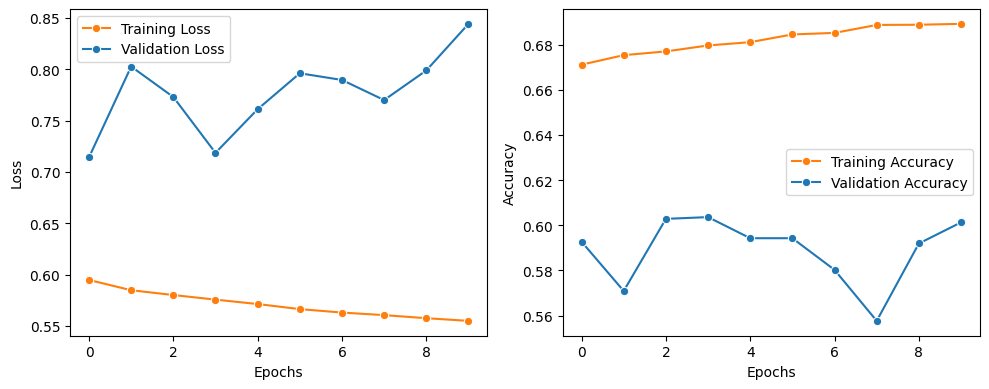

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, sub = plt.subplots(1, 2, figsize=(10, 4))

# Plot the data in each subplot using seaborn
sns.lineplot(train_loss3, ax=sub[0],label='Training Loss', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(val_loss3, ax=sub[0], label='Validation Loss', marker='o', linestyle='-', color='tab:blue')
# sub[0].set_title('Epochs = 10')
sub[0].set_xlabel('Epochs')
sub[0].set_ylabel('Loss')

# sns.lineplot(x=epochs, y=losses_2, ax=axes[0, 1])
sns.lineplot(train_acc3, ax=sub[1],label='Training Accuracy', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(val_acc3, ax=sub[1], label='Validation Accuracy', marker='o', linestyle='-', color='tab:blue')
# sub[1].set_title('Epochs = 10')
sub[1].set_xlabel('Epochs')
sub[1].set_ylabel('Accuracy')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [28]:
num_correct = 0
num_samples = 0
# load the best model
model.load_state_dict(torch.load("attn_liar3.pt", map_location=device))
model.eval()
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device=device)
        y = y.to(device=device)
        scores = model(x)
        predictions = torch.round(torch.sigmoid(scores))
        num_correct += (predictions == y.unsqueeze(1)).sum()
        num_samples += predictions.size(0)
        y_pred.extend(predictions.cpu().numpy())
    print("Got {} / {} with accuracy {} on test data".format(num_correct, num_samples, float(num_correct)/float(num_samples)))

y_pred = np.array(y_pred)

Got 763 / 1267 with accuracy 0.6022099447513812 on test data


In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.55      0.46      0.50       553
         1.0       0.63      0.71      0.67       714

    accuracy                           0.60      1267
   macro avg       0.59      0.59      0.59      1267
weighted avg       0.60      0.60      0.60      1267



**3. SGD**

In [30]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_acc = 0
# Training loop
num_epochs = 10
train_loss4 = []
val_loss4 = []
train_acc4 = []
val_acc4 = []
for epoch in range(num_epochs):
    train_batch_loss = []
    num_correct = 0
    num_samples = 0
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)
        # forward
        scores = model(data)
        loss = criterion(scores, targets.unsqueeze(1))
        train_batch_loss.append(loss.item())
        predictions = torch.round(torch.sigmoid(scores))
        num_correct += (predictions == targets.unsqueeze(1)).sum()
        num_samples += predictions.size(0)
        # print(" Epoch: {} | Batch: {} | Loss: {}".format(epoch, batch_idx, loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss4.append(sum(train_batch_loss)/len(train_batch_loss))
    train_acc4.append(float(num_correct)/float(num_samples))

    val_batch_loss = []
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            scores = model(x)
            loss = criterion(scores, y.unsqueeze(1))
            val_batch_loss.append(loss.item())
            predictions = torch.round(torch.sigmoid(scores))
            num_correct += (predictions == y.unsqueeze(1)).sum()
            num_samples += predictions.size(0)
        # print("Got {} / {} with accuracy {}".format(num_correct, num_samples, float(num_correct)/float(num_samples)))


        acc = float(num_correct)/float(num_samples)
        
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "attn_liar4.pt")
        # print('Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'.format(epoch+1, train_loss, train_acc, val_loss, val_acc))
    
    val_acc4.append(acc)
    val_loss4.append(sum(val_batch_loss)/len(val_batch_loss))
    print('Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Valid Loss: {:.4f}, Valid Acc: {:.4f}'.format(epoch+1, train_loss4[-1], train_acc4[-1], val_loss4[-1], val_acc4[-1]))



Epoch: 1, Train Loss: 0.5580, Train Acc: 0.6945, Valid Loss: 0.7355, Valid Acc: 0.5966
Epoch: 2, Train Loss: 0.5530, Train Acc: 0.6968, Valid Loss: 0.7455, Valid Acc: 0.5997
Epoch: 3, Train Loss: 0.5518, Train Acc: 0.6963, Valid Loss: 0.7506, Valid Acc: 0.5942
Epoch: 4, Train Loss: 0.5515, Train Acc: 0.6951, Valid Loss: 0.7543, Valid Acc: 0.5942
Epoch: 5, Train Loss: 0.5506, Train Acc: 0.6947, Valid Loss: 0.7543, Valid Acc: 0.5942
Epoch: 6, Train Loss: 0.5515, Train Acc: 0.6942, Valid Loss: 0.7546, Valid Acc: 0.5950
Epoch: 7, Train Loss: 0.5504, Train Acc: 0.6978, Valid Loss: 0.7563, Valid Acc: 0.5958
Epoch: 8, Train Loss: 0.5499, Train Acc: 0.6965, Valid Loss: 0.7577, Valid Acc: 0.5958
Epoch: 9, Train Loss: 0.5501, Train Acc: 0.6971, Valid Loss: 0.7589, Valid Acc: 0.5942
Epoch: 10, Train Loss: 0.5499, Train Acc: 0.6972, Valid Loss: 0.7594, Valid Acc: 0.5974


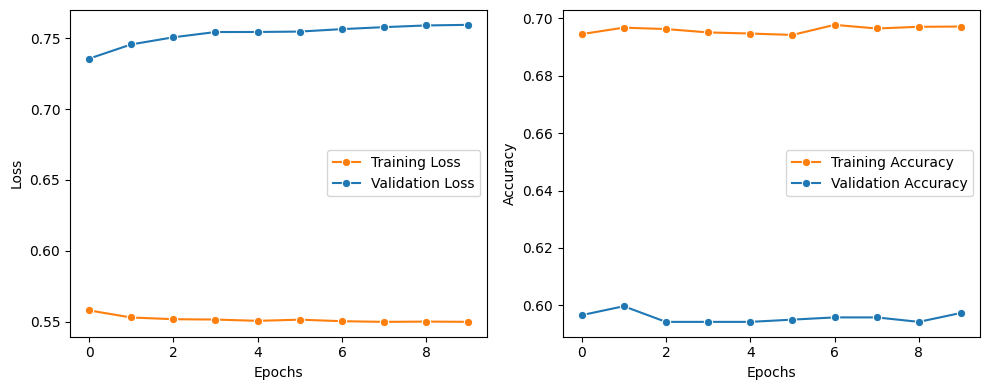

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, sub = plt.subplots(1, 2, figsize=(10, 4))

# Plot the data in each subplot using seaborn
sns.lineplot(train_loss4, ax=sub[0],label='Training Loss', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(val_loss4, ax=sub[0], label='Validation Loss', marker='o', linestyle='-', color='tab:blue')
# sub[0].set_title('Epochs = 10')
sub[0].set_xlabel('Epochs')
sub[0].set_ylabel('Loss')

# sns.lineplot(x=epochs, y=losses_2, ax=axes[0, 1])
sns.lineplot(train_acc4, ax=sub[1],label='Training Accuracy', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(val_acc4, ax=sub[1], label='Validation Accuracy', marker='o', linestyle='-', color='tab:blue')
# sub[1].set_title('Epochs = 10')
sub[1].set_xlabel('Epochs')
sub[1].set_ylabel('Accuracy')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [33]:
num_correct = 0
num_samples = 0
# load the best model
model.load_state_dict(torch.load("attn_liar4.pt", map_location=device))
model.eval()
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device=device)
        y = y.to(device=device)
        scores = model(x)
        predictions = torch.round(torch.sigmoid(scores))
        num_correct += (predictions == y.unsqueeze(1)).sum()
        num_samples += predictions.size(0)
        y_pred.extend(predictions.cpu().numpy())
    print("Got {} / {} with accuracy {} on test data".format(num_correct, num_samples, float(num_correct)/float(num_samples)))

y_pred = np.array(y_pred)

Got 766 / 1267 with accuracy 0.6045777426992897 on test data


In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.56      0.46      0.50       553
         1.0       0.63      0.72      0.67       714

    accuracy                           0.60      1267
   macro avg       0.59      0.59      0.59      1267
weighted avg       0.60      0.60      0.60      1267



# **Comparisions**

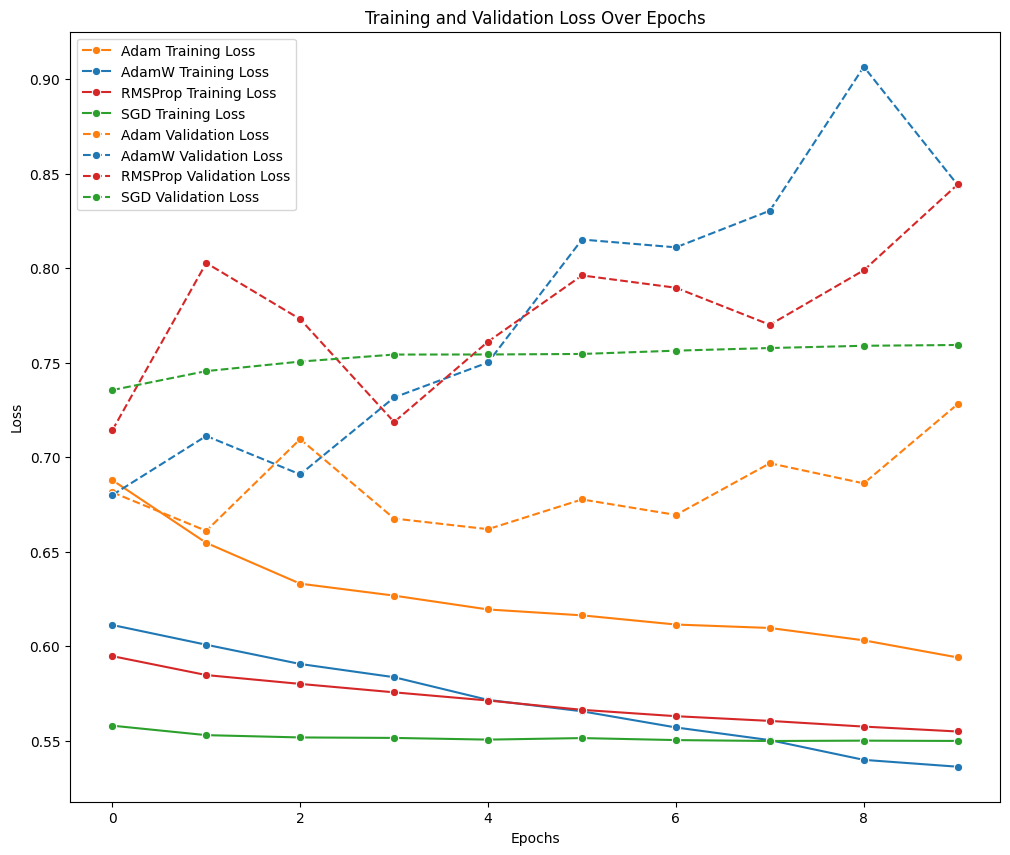

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a single plot with two lines for training and validation losses
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the training losses
sns.lineplot(x=range(len(train_loss1)), y=train_loss1, label='Adam Training Loss', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(x=range(len(train_loss2)), y=train_loss2, label='AdamW Training Loss', marker='o', linestyle='-', color='tab:blue')
sns.lineplot(x=range(len(train_loss3)), y=train_loss3, label='RMSProp Training Loss', marker='o', linestyle='-', color='tab:red')
sns.lineplot(x=range(len(train_loss4)), y=train_loss4, label='SGD Training Loss', marker='o', linestyle='-', color='tab:green')

# Plot the validation losses
sns.lineplot(x=range(len(val_loss1)), y=val_loss1, label='Adam Validation Loss', marker='o', linestyle='--', color='tab:orange')
sns.lineplot(x=range(len(val_loss2)), y=val_loss2, label='AdamW Validation Loss', marker='o', linestyle='--', color='tab:blue')
sns.lineplot(x=range(len(val_loss3)), y=val_loss3, label='RMSProp Validation Loss', marker='o', linestyle='--', color='tab:red')
sns.lineplot(x=range(len(val_loss4)), y=val_loss4, label='SGD Validation Loss', marker='o', linestyle='--', color='tab:green')

# Set labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss Over Epochs')

# Show legend
ax.legend()

# Show the plot
plt.show()


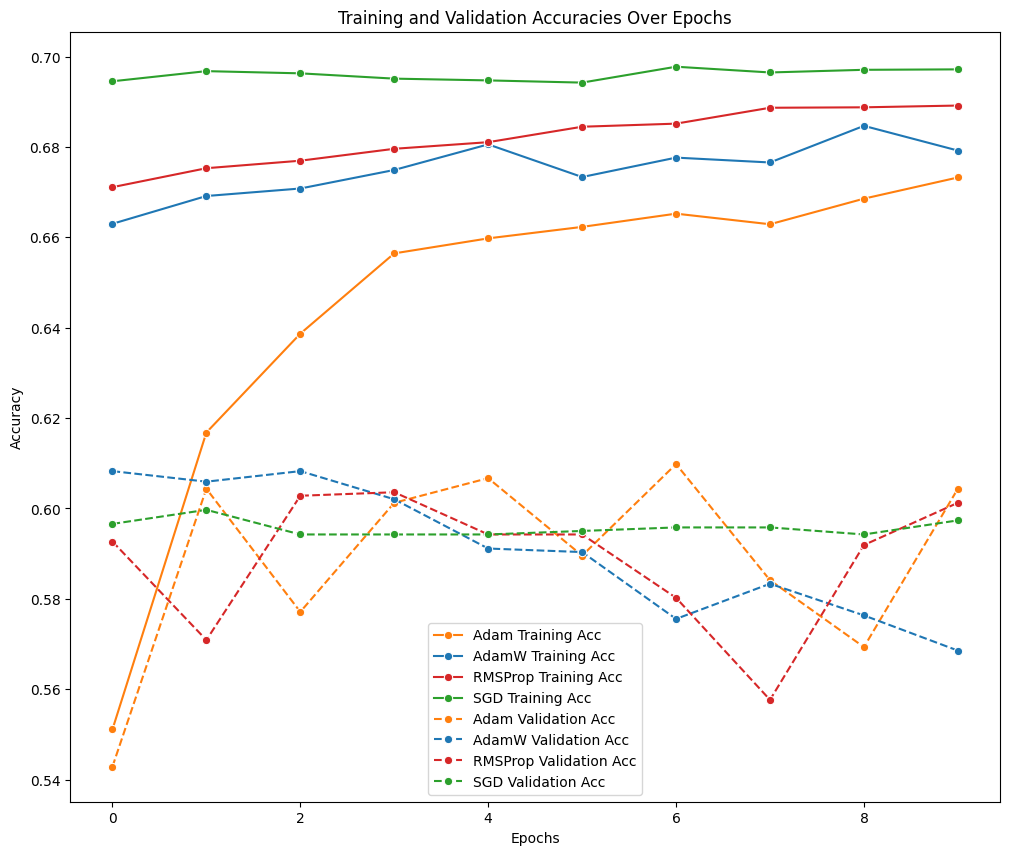

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a single plot with two lines for training and validation accs
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the training accs
sns.lineplot(x=range(len(train_acc1)), y=train_acc1, label='Adam Training Acc', marker='o', linestyle='-', color='tab:orange')
sns.lineplot(x=range(len(train_acc2)), y=train_acc2, label='AdamW Training Acc', marker='o', linestyle='-', color='tab:blue')
sns.lineplot(x=range(len(train_acc3)), y=train_acc3, label='RMSProp Training Acc', marker='o', linestyle='-', color='tab:red')
sns.lineplot(x=range(len(train_acc4)), y=train_acc4, label='SGD Training Acc', marker='o', linestyle='-', color='tab:green')

# Plot the validation accs
sns.lineplot(x=range(len(val_acc1)), y=val_acc1, label='Adam Validation Acc', marker='o', linestyle='--', color='tab:orange')
sns.lineplot(x=range(len(val_acc2)), y=val_acc2, label='AdamW Validation Acc', marker='o', linestyle='--', color='tab:blue')
sns.lineplot(x=range(len(val_acc3)), y=val_acc3, label='RMSProp Validation Acc', marker='o', linestyle='--', color='tab:red')
sns.lineplot(x=range(len(val_acc4)), y=val_acc4, label='SGD Validation Acc', marker='o', linestyle='--', color='tab:green')

# Set labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracies Over Epochs')

# Show legend
ax.legend()

# Show the plot
plt.show()
